Минимальная общая дата: 2022-06-09 00:00:00
            Open_BTC  High_BTC   Low_BTC  Close_BTC    Volume_BTC  \
2022-06-09  30117.01  30672.56  29920.56   29990.88    967.428486   
2022-06-10  29975.75  30333.81  28832.83   28937.05   2512.622358   
2022-06-11  28951.83  29403.62  28085.75   28571.03   1665.995847   
2022-06-12  28571.75  28656.81  26868.19   27387.23   2182.012839   
2022-06-13  27383.72  27506.62  22600.00   23144.08  11560.651179   

            Open_TETHER  High_TETHER  Low_TETHER  Close_TETHER  Volume_TETHER  \
2022-06-09        0.999        1.000       0.998         0.999   1.439351e+10   
2022-06-10        0.999        1.000       0.999         0.999   1.723082e+10   
2022-06-11        0.999        0.999       0.999         0.999   1.636120e+10   
2022-06-12        0.999        0.999       0.999         0.999   2.057387e+10   
2022-06-13        0.999        0.999       0.997         0.999   4.185709e+10   

            ...  Low_SOL  Close_SOL    Volume_SOL  Cap

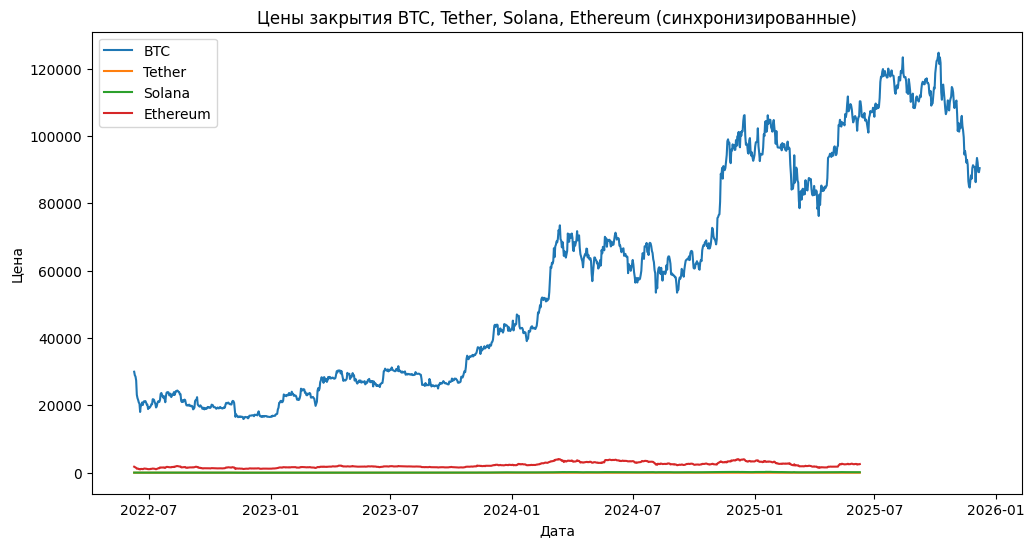

Корреляции:
               Close_BTC  Close_TETHER  Close_SOL  Close_ETH
Close_BTC      1.000000     -0.026855   0.932061   0.740865
Close_TETHER  -0.026855      1.000000  -0.039840  -0.003863
Close_SOL      0.932061     -0.039840   1.000000   0.855350
Close_ETH      0.740865     -0.003863   0.855350   1.000000


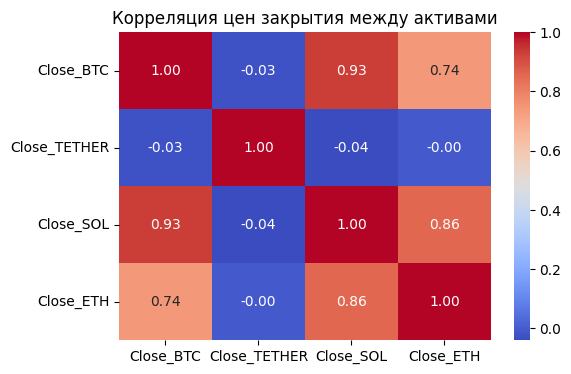

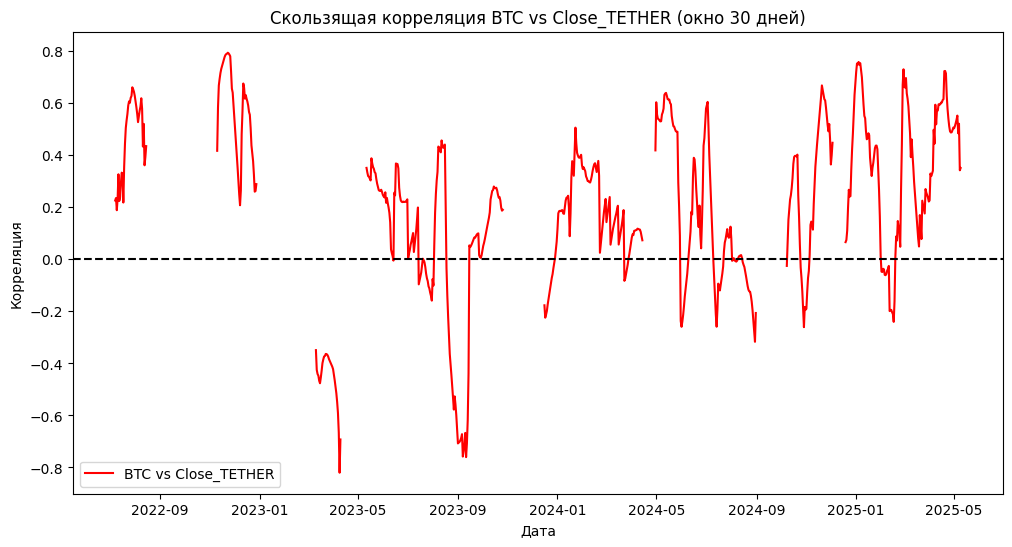

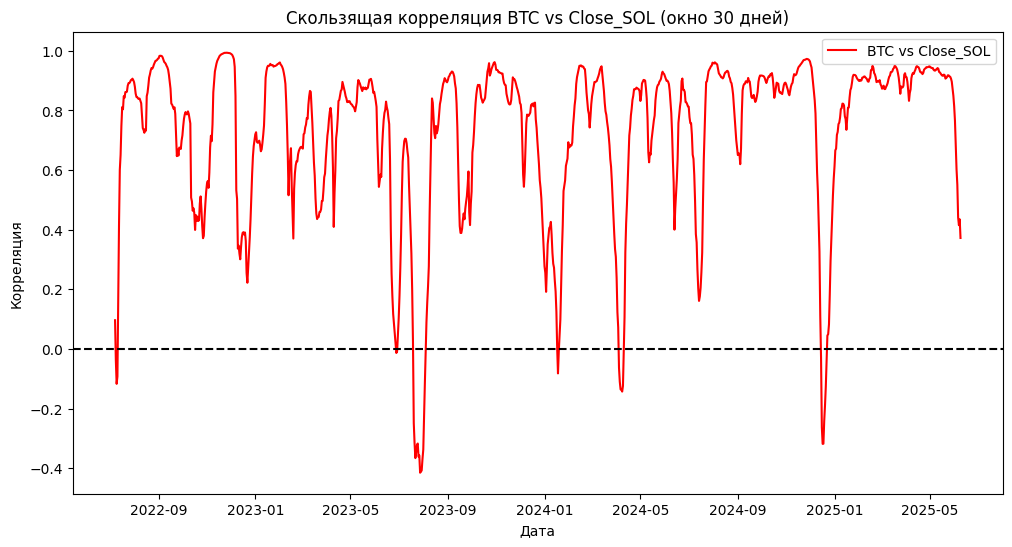

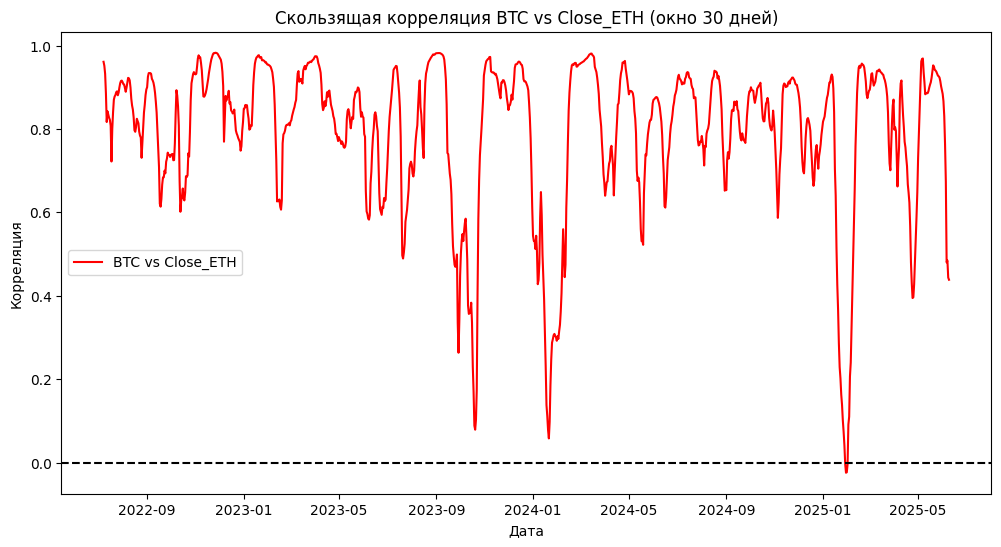

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- BTC (минутные данные с Unix timestamp) ---
df_btc = pd.read_csv("btc/btc.csv")
df_btc["Timestamp"] = pd.to_datetime(df_btc["Timestamp"], unit="s")  # преобразуем Unix-время
df_btc = df_btc.set_index("Timestamp")

# Ресемплинг BTC в дневные свечи
df_btc_daily = df_btc.resample("1D").agg({
    "Open":"first",
    "High":"max",
    "Low":"min",
    "Close":"last",
    "Volume":"sum"
}).dropna()
df_btc_daily = df_btc_daily.add_suffix("_BTC")

# --- Функция очистки дневных датасетов ---
def clean_daily(path, asset_name):
    df = pd.read_csv(path)
    df["Дата"] = pd.to_datetime(df["Дата"])
    df = df.set_index("Дата")

    # Числовые колонки
    for col in ["Открытие","Макс","Мин","Средняя","Закрыть","Объём","Капитализ."]:
        df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

    # Переименуем в единый формат
    df = df.rename(columns={
        "Открытие":"Open",
        "Макс":"High",
        "Мин":"Low",
        "Закрыть":"Close",
        "Объём":"Volume",
        "Капитализ.":"Capitalization"
    })

    # Оставляем только нужные колонки
    df = df[["Open","High","Low","Close","Volume","Capitalization"]]

    # Добавляем суффикс актива
    df = df.add_suffix(f"_{asset_name}")

    return df

# --- Загружаем дневные датасеты ---
df_tether   = clean_daily("btc/tether-historical-data.csv", "TETHER")
df_solana   = clean_daily("btc/solana-historical-data.csv", "SOL")
df_ethereum = clean_daily("btc/ethereum-historical-data.csv", "ETH")

# --- Объединяем всё в один DataFrame ---
combined = df_btc_daily.join([df_tether, df_solana, df_ethereum], how="outer")

# --- Обрезаем по минимальной дате, где все активы имеют данные ---
close_cols = ["Close_BTC","Close_TETHER","Close_SOL","Close_ETH"]
min_date = combined[close_cols].dropna().index.min()
print("Минимальная общая дата:", min_date)

combined_trimmed = combined.loc[min_date:]

# --- Проверка ---
print(combined_trimmed.head())
print(combined_trimmed.info())

# --- Визуализация цен закрытия ---
plt.figure(figsize=(12,6))
plt.plot(combined_trimmed.index, combined_trimmed["Close_BTC"], label="BTC")
plt.plot(combined_trimmed.index, combined_trimmed["Close_TETHER"], label="Tether")
plt.plot(combined_trimmed.index, combined_trimmed["Close_SOL"], label="Solana")
plt.plot(combined_trimmed.index, combined_trimmed["Close_ETH"], label="Ethereum")
plt.legend()
plt.title("Цены закрытия BTC, Tether, Solana, Ethereum (синхронизированные)")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.show()

# --- Корреляции и тепловая карта ---
corr_matrix = combined_trimmed[close_cols].corr()
print("Корреляции:\n", corr_matrix)

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляция цен закрытия между активами")
plt.show()

# --- Скользящая корреляция BTC vs другие ---
window = 30  # окно в днях
for asset in ["Close_TETHER","Close_SOL","Close_ETH"]:
    rolling_corr = combined_trimmed["Close_BTC"].rolling(window).corr(combined_trimmed[asset])
    plt.figure(figsize=(12,6))
    plt.plot(rolling_corr, label=f"BTC vs {asset}", color="red")
    plt.axhline(0, color="black", linestyle="--")
    plt.title(f"Скользящая корреляция BTC vs {asset} (окно {window} дней)")
    plt.xlabel("Дата")
    plt.ylabel("Корреляция")
    plt.legend()
    plt.show()


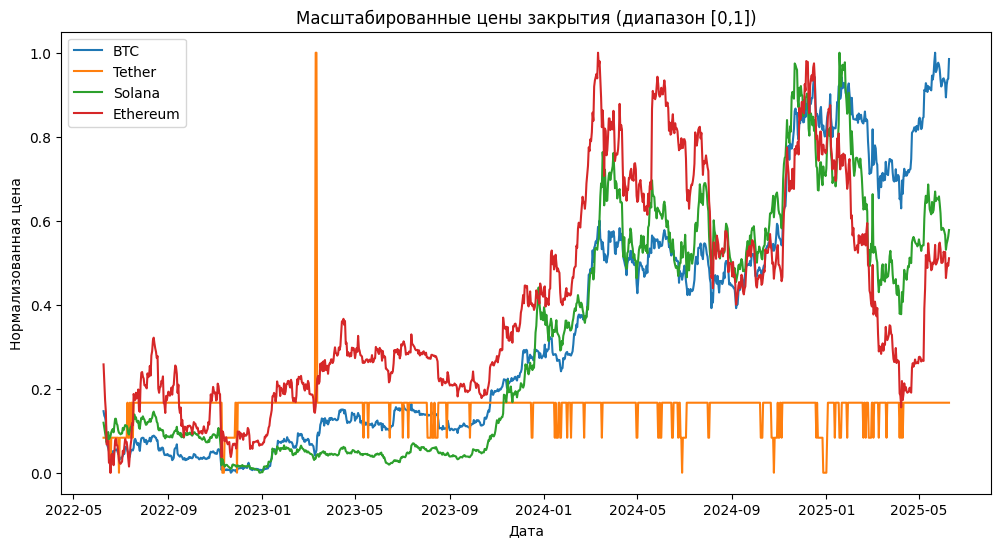

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Берём только цены закрытия
close_cols = ["Close_BTC","Close_TETHER","Close_SOL","Close_ETH"]
close_data = combined_trimmed[close_cols].dropna()

# Масштабируем в диапазон [0,1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(close_data)

# Превращаем обратно в DataFrame
scaled_df = pd.DataFrame(scaled, index=close_data.index, columns=close_cols)

# --- График ---
plt.figure(figsize=(12,6))
plt.plot(scaled_df.index, scaled_df["Close_BTC"], label="BTC")
plt.plot(scaled_df.index, scaled_df["Close_TETHER"], label="Tether")
plt.plot(scaled_df.index, scaled_df["Close_SOL"], label="Solana")
plt.plot(scaled_df.index, scaled_df["Close_ETH"], label="Ethereum")
plt.legend()
plt.title("Масштабированные цены закрытия (диапазон [0,1])")
plt.xlabel("Дата")
plt.ylabel("Нормализованная цена")
plt.show()


Видно, что solana и Эфир напрямую зависят от биткоина. Графики имеют очень схожую структуру. Обучив модель на биткоине, можно с высокой вероятностью сказать, что она сможет работать и на остальных

Tether практически всегда на одном уровне. Периодически падает и возвращается обратно. Нет какой-то зависимости, на всё тамлайне одинаковый

In [29]:
print(df_tether.head())
print(df_tether.info())
print(df_tether.describe())

            Open_TETHER  High_TETHER  Low_TETHER  Close_TETHER  Volume_TETHER  \
Дата                                                                            
2025-06-09          1.0          1.0         1.0           1.0   3.463049e+10   
2025-06-08          1.0          1.0         1.0           1.0   2.669405e+10   
2025-06-07          1.0          1.0         1.0           1.0   2.833663e+10   
2025-06-06          1.0          1.0         1.0           1.0   3.995261e+10   
2025-06-05          1.0          1.0         1.0           1.0   4.279202e+10   

            Capitalization_TETHER  
Дата                               
2025-06-09           1.548317e+11  
2025-06-08           1.548158e+11  
2025-06-07           1.545372e+11  
2025-06-06           1.542250e+11  
2025-06-05           1.538887e+11  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1097 entries, 2025-06-09 to 2022-06-09
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
--- 

Epoch 1/20


d:\tms\venv_time\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0483 - val_loss: 0.1282
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - val_loss: 0.0379
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.6939e-04 - val_loss: 0.0399
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.6260e-04 - val_loss: 0.0332
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1690e-04 - val_loss: 0.0308
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5327e-04 - val_loss: 0.0326
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3293e-04 - val_loss: 0.0275
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7884e-04 - val_loss: 0.0265
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4013e-04 - val_loss: 0.0258
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0908e-04 - val_loss: 0.0245
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6654e-04 - val_loss: 0.0210
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11m

d:\tms\venv_time\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0312
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 0.0113
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8262e-04 - val_loss: 0.0084
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5547e-04 - val_loss: 0.0024
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7125e-04 - val_loss: 0.0023
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8594e-04 - val_loss: 0.0029
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5908e-04 - val_loss: 0.0024
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2697e-04 - val_loss: 0.0036
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3103e-04 - val_loss: 0.0021
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8720e-04 - val_loss: 0.0034
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3742e-04 - val_loss: 0.0024
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

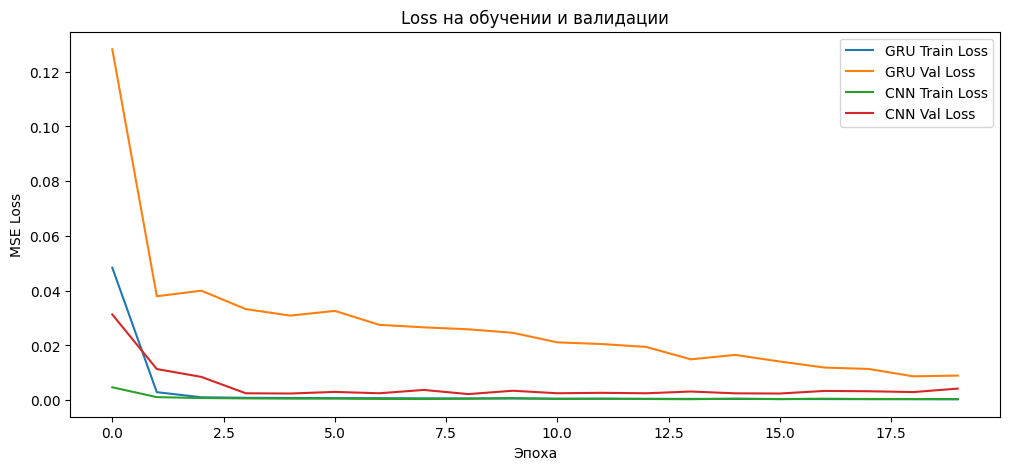

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


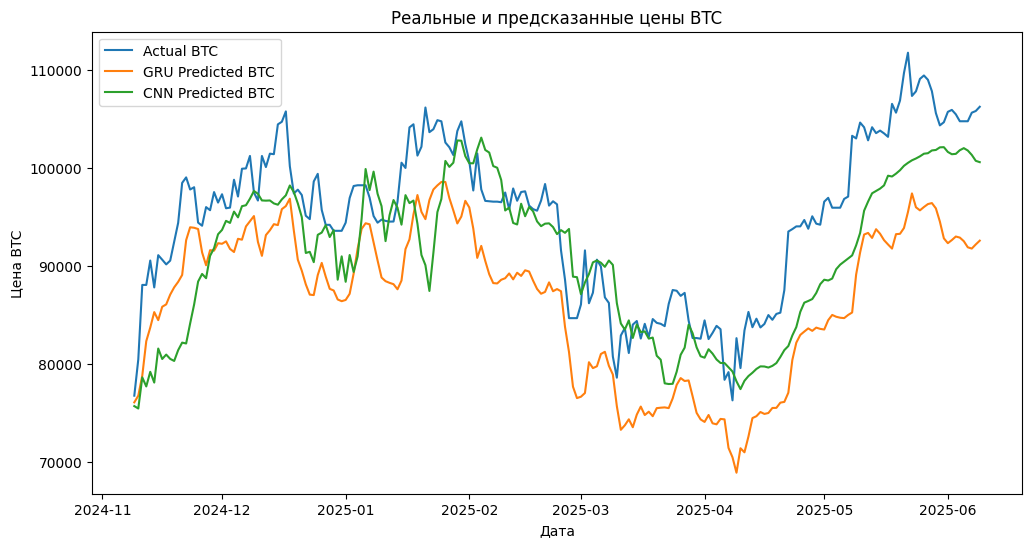

In [77]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- Используем только цены закрытия ---
features = close_cols  # ["Close_BTC","Close_TETHER","Close_SOL","Close_ETH"]
data = combined_trimmed[features].values

# --- Нормализация ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# --- Создание последовательностей ---
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, 0])  # прогнозируем BTC
    return np.array(X), np.array(y)

SEQ_LEN = 30
X, y = create_sequences(data_scaled, SEQ_LEN)

# --- Train/Test split ---
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Модель GRU ---
gru_model = Sequential([
    GRU(64, input_shape=(SEQ_LEN, X.shape[2]), return_sequences=False),
    Dense(1)
])
gru_model.compile(optimizer=Adam(0.001), loss='mse')
gru_history = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# --- Модель CNN1D ---
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(SEQ_LEN, X.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer=Adam(0.001), loss='mse')
cnn_history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# --- Визуализация loss ---
plt.figure(figsize=(12,5))
plt.plot(gru_history.history['loss'], label='GRU Train Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Val Loss')
plt.plot(cnn_history.history['loss'], label='CNN Train Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Val Loss')
plt.title("Loss на обучении и валидации")
plt.xlabel("Эпоха")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# --- Предсказания ---
y_pred_gru = gru_model.predict(X_test)
y_pred_cnn = cnn_model.predict(X_test)

# --- Инвертируем масштаб для визуализации ---
y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1,1), np.zeros((len(y_test), data.shape[1]-1))]))[:,0]
y_pred_gru_inv = scaler.inverse_transform(np.hstack([y_pred_gru, np.zeros((len(y_pred_gru), data.shape[1]-1))]))[:,0]
y_pred_cnn_inv = scaler.inverse_transform(np.hstack([y_pred_cnn, np.zeros((len(y_pred_cnn), data.shape[1]-1))]))[:,0]

# --- Визуализация реальных и предсказанных цен BTC ---
plt.figure(figsize=(12,6))
plt.plot(combined_trimmed.index[-len(y_test):], y_test_inv, label='Actual BTC')
plt.plot(combined_trimmed.index[-len(y_test):], y_pred_gru_inv, label='GRU Predicted BTC')
plt.plot(combined_trimmed.index[-len(y_test):], y_pred_cnn_inv, label='CNN Predicted BTC')
plt.title("Реальные и предсказанные цены BTC")
plt.xlabel("Дата")
plt.ylabel("Цена BTC")
plt.legend()
plt.show()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


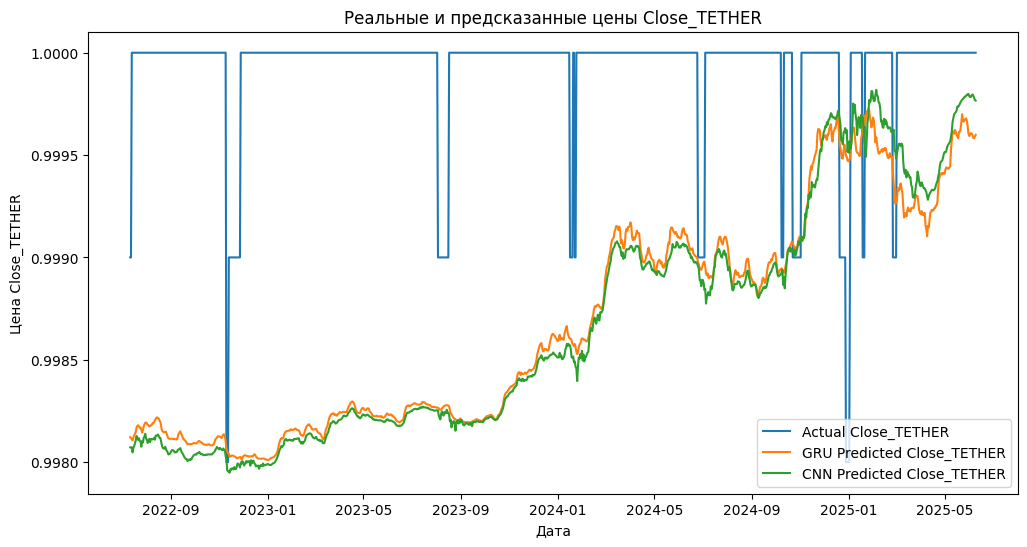

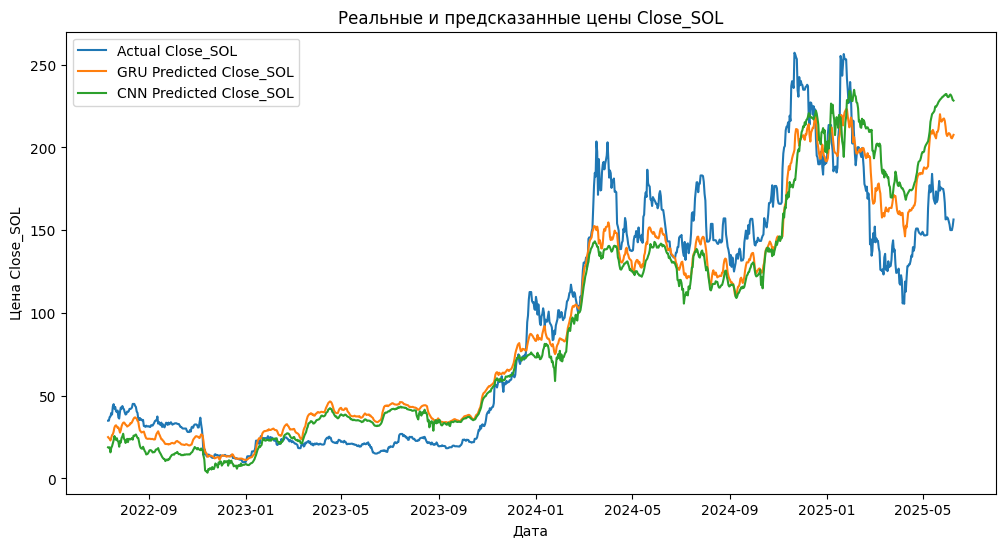

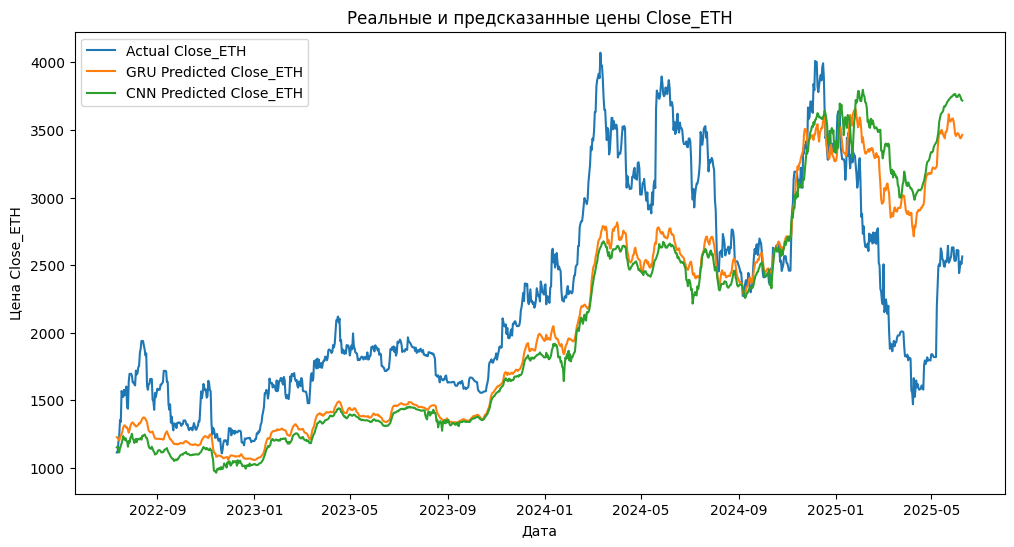

In [79]:
assets = ["Close_TETHER", "Close_SOL", "Close_ETH"]

y_tests_inv = {}
y_preds_gru_inv = {}
y_preds_cnn_inv = {}

for asset in assets:
    col_idx = features.index(asset)  # индекс текущего актива в features
    y_current = data_scaled[SEQ_LEN:, col_idx]  # истинные значения
    X_current = X  # входные последовательности те же

    # Предсказания моделей
    y_pred_gru = gru_model.predict(X_current)
    y_pred_cnn = cnn_model.predict(X_current)

    # Функция для восстановления масштаба
    def invert_scale(y_scaled, col_idx):
        tmp = np.zeros((len(y_scaled), data.shape[1]))
        tmp[:, col_idx] = y_scaled.flatten()
        return scaler.inverse_transform(tmp)[:, col_idx]

    # Сохраняем результаты
    y_tests_inv[asset] = invert_scale(y_current, col_idx)
    y_preds_gru_inv[asset] = invert_scale(y_pred_gru, col_idx)
    y_preds_cnn_inv[asset] = invert_scale(y_pred_cnn, col_idx)

# --- Визуализация ---
import matplotlib.pyplot as plt

for asset in assets:
    plt.figure(figsize=(12,6))
    plt.plot(combined_trimmed.index[-len(y_tests_inv[asset]):], y_tests_inv[asset], label=f'Actual {asset}')
    plt.plot(combined_trimmed.index[-len(y_tests_inv[asset]):], y_preds_gru_inv[asset], label=f'GRU Predicted {asset}')
    plt.plot(combined_trimmed.index[-len(y_tests_inv[asset]):], y_preds_cnn_inv[asset], label=f'CNN Predicted {asset}')
    plt.title(f'Реальные и предсказанные цены {asset}')
    plt.xlabel("Дата")
    plt.ylabel(f"Цена {asset}")
    plt.legend()
    plt.show()
